#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

The right activation function to insert in the output layer is *sigmoidal*, because the activity we want to perform is a binary classification. That activation function gives a value between 0 and 1. So, given an input, the sigmoidal function indicates whether that example belongs to a specific class or not. The sigmoidal function doesn't just return two possible values (0 and 1). It is a function that returns a value in the range $(0,1)$ and is differentiable and continuous.

The loss function that fits the task we want to perform is the *binary cross-entropy*. The task of this exercise is to recognize if a given input belongs to a class or to another class, so the task is a binary classification. The labels of the two classes can be expressed in a binary way, such as, 0 and 1 or A and B.

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [39]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [40]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 30s 146ms/step - loss: 0.6861 - accuracy: 0.5409 - val_loss: 0.5178 - val_accuracy: 0.7596
Epoch 2/10
196/196 [==============================] - 28s 144ms/step - loss: 0.4585 - accuracy: 0.7938 - val_loss: 0.4011 - val_accuracy: 0.8343
Epoch 3/10
196/196 [==============================] - 28s 143ms/step - loss: 0.2988 - accuracy: 0.8828 - val_loss: 0.3738 - val_accuracy: 0.8396
Epoch 4/10
196/196 [==============================] - 28s 144ms/step - loss: 0.2220 - accuracy: 0.9168 - val_loss: 0.3866 - val_accuracy: 0.8370
Epoch 5/10
196/196 [==============================] - 28s 144ms/step - loss: 0.1685 - accuracy: 0.9405 - val_loss: 0.4017 - val_accuracy: 0.8419
Epoch 6/10
196/196 [==============================] - 28s 144ms/step - loss: 0.1107 - accuracy: 0.9645 - val_loss: 0.4397 - val_accuracy: 0.8534
Epoch 7/10
196/196 [==============================] - 28s 144ms/step - loss: 0.0887 - accuracy: 0.9729 - val_loss: 0.4947 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 8s - loss: 0.5927 - accuracy: 0.8405
accuracy: 84.05%


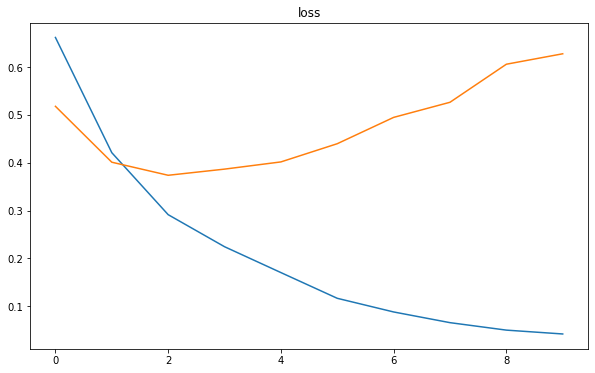

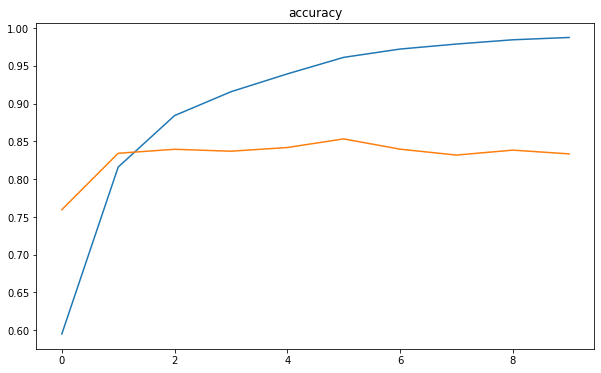

In [41]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(14))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 14)                1400      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 50s 246ms/step - loss: 0.6489 - accuracy: 0.6254 - val_loss: 0.3945 - val_accuracy: 0.8364
Epoch 2/10
196/196 [==============================] - 50s 256ms/step - loss: 0.3336 - accuracy: 0.8693 - val_loss: 0.3636 - val_accuracy: 0.8440
Epoch 3/10
196/196 [==============================] - 51s 258ms/step - loss: 0.2364 - accuracy: 0.9128 - val_loss: 0.3043 - val_accuracy: 0.8767
Epoch 4/10
196/196 [==============================] - 51s 261ms/step - loss: 0.1741 - accuracy: 0.9409 - val_loss: 0.3144 - val_accuracy: 0.8669
Epoch 5/10
196/196 [==============================] - 52s 264ms/step - loss: 0.1424 - accuracy: 0.9536 - val_loss: 0.3940 - val_accuracy: 0.8447
Epoch 6/10
196/196 [==============================] - 52s 264ms/step - loss: 0.1263 - accuracy: 0.9606 - val_loss: 0.3768 - val_accuracy: 0.8676
Epoch 7/10
196/196 [==============================] - 51s 261ms/step - loss: 0.1045 - accuracy: 0.9697 - val_loss: 0.4191 - val_ac

391/391 - 10s - loss: 0.4163 - accuracy: 0.8582
accuracy: 85.82%


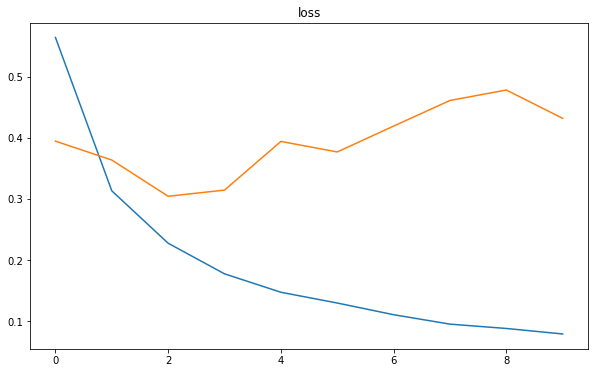

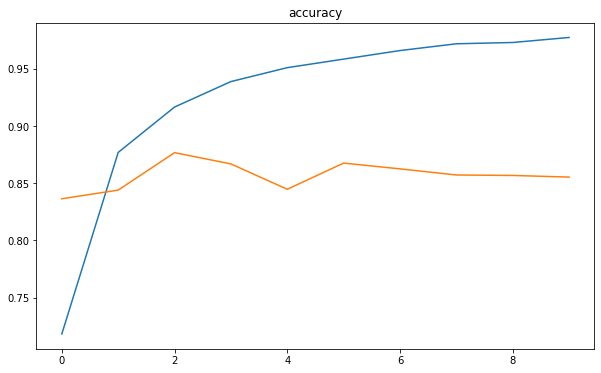

In [37]:
plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 50s 243ms/step - loss: 0.6755 - accuracy: 0.5576 - val_loss: 0.5268 - val_accuracy: 0.7502
Epoch 2/10
196/196 [==============================] - 52s 264ms/step - loss: 0.4293 - accuracy: 0.8119 - val_loss: 0.4037 - val_accuracy: 0.8183
Epoch 3/10
196/196 [==============================] - 52s 264ms/step - loss: 0.2721 - accuracy: 0.8920 - val_loss: 0.3413 - val_accuracy: 0.8542
Epoch 4/10
196/196 [==============================] - 51s 262ms/step - loss: 0.2032 - accuracy: 0.9253 - val_loss: 0.3371 - val_accuracy: 0.8624
Epoch 5/10
196/196 [==============================] - 52s 264ms/step - loss: 0.1667 - accuracy: 0.9421 - val_loss: 0.3548 - val_accuracy: 0.8592
Epoch 6/10
196/196 [==============================] - 51s 260ms/step - loss: 0.1345 - accuracy: 0.9557 - val_loss: 0.3809 - val_accuracy: 0.8626
Epoch 7/10
196/196 [==============================] - 53s 272ms/step - loss: 0.1149 - accuracy: 0.9645 - val_loss: 0.4053 - val_ac

391/391 - 9s - loss: 0.5117 - accuracy: 0.8489
accuracy: 84.89%


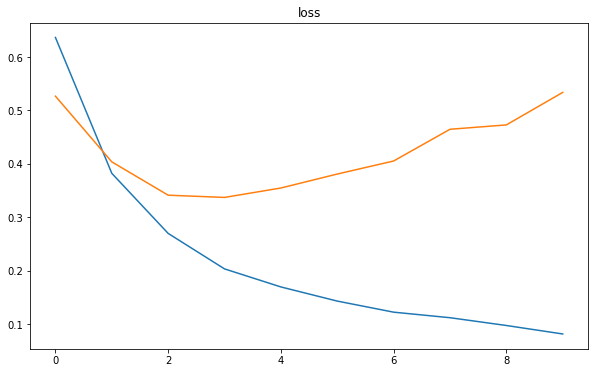

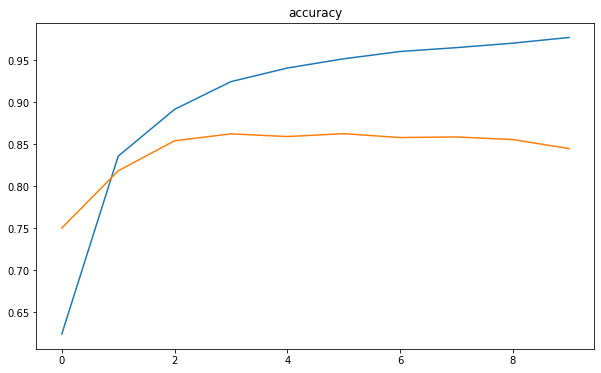

In [33]:
plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

**Performance**
* **SimpleRNN**: loss: 0.5927, accuracy: 84.05%;
* **LSTM**: loss: 0.4163, accuracy: 85.82%;
* **GRU**: loss: 0.5117, accuracy: 84.89%.

LSTM and GRU have achieved better accuracy and lower losses than SimpleRNN. The main reason is that LSTM and GRU are specific architectures designed to perform in this application field. In particular, these architectures are able to cope with the vanishing gradient problem, a common problem of RNNs.

If we focus on the results of LSTM and GRU, we can notice that LSTM performed (slightly) better than GRU. We have to remember that the LSTM architecture is a generalization of the GRU architecture. So the GRU architecture is "simpler" than the LSTM architecture and this fact can influence on the vanishing gradient problem: maybe, LSTM is able to cope better this kind of problem than GRU.

**Number of parameters and training time**
* **SimpleRNN**: 1376 (total parameters of the network: 101409);
* **LSTM**: 1400 (total parameters of the network: 101415);
* **GRU**: 1344 (total parameters of the network: 101361).

We can notice that the SimpleRNN is faster in the training phase than LSTM and GRU. This is a side effect of the complexity of the LSTM and GRU architectures. The time required by LSTM and GRU are roughly the same. We can notice that the time required by GRU is slightly smaller than LSTM because GRU has a simpler architecture than LSTM and, from this fact, GRU has a less number of parameters to be learnt than LSTM.

**Number of units**
* **SimpleRNN**: 32;
* **LSTM**: 14;
* **GRU**: 16.

To keep the same number of parameters of the SimpleRNN model, I found that the ideal number of units for LSTM is 14 and for GRU is 16. The reason that the GRU has more units than LSTM is that the GRU architecture has less parameters to be learnt. Less parameters may come at the cost of decreased expressibility. So, if LSTM and GRU have the same number of units, GRU will have a less number of parameters to be learnt than LSTM model.

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 111s 551ms/step - loss: 0.6397 - accuracy: 0.6081 - val_loss: 0.3696 - val_accuracy: 0.8452
Epoch 2/5
196/196 [==============================] - 106s 542ms/step - loss: 0.3235 - accuracy: 0.8713 - val_loss: 0.3002 - val_accuracy: 0.8744
Epoch 3/5
196/196 [==============================] - 106s 541ms/step - loss: 0.2170 - ac

391/391 - 18s - loss: 0.3203 - accuracy: 0.8767
accuracy: 87.67%


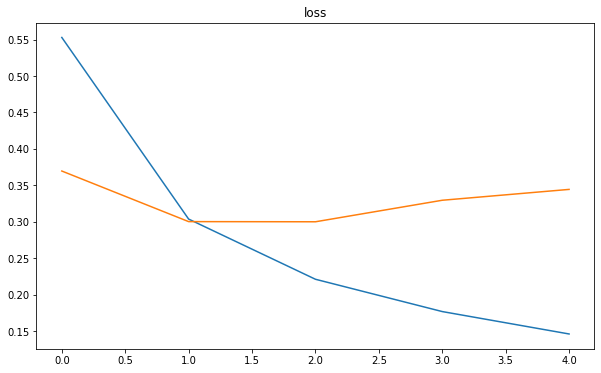

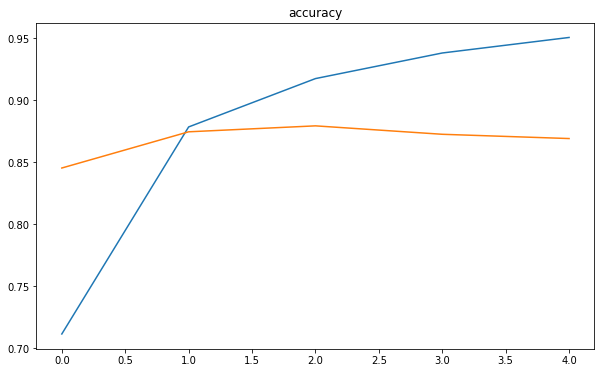

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.4))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/5
196/196 [==============================] - 114s 561ms/step - loss: 0.6457 - accuracy: 0.6011 - val_loss: 0.3980 - val_accuracy: 0.8426
Epoch 2/5
196/196 [==============================] - 108s 550ms/step - loss: 0.3391 - accuracy: 0.8633 - val_loss: 0.3075 - val_accuracy: 0.8708
Epoch 3/5
196/196 [==============================] - 108s 550ms/step - loss: 0.2423 - accuracy: 0.9073 - val_loss: 0.2872 - val_accuracy: 0.8786
Epoch 4/5
196/196 [==============================] - 108s 550ms/step - loss: 0.2032 - accuracy: 0.9260 - val_loss: 0.2933 - val_accuracy: 0.8798
Epoch 5/5
196/196 [==============================] - 108s 552ms/step - loss: 0.1703 - accuracy: 0.9399 - val_loss: 0.3041 - val_accuracy: 0.8778


391/391 - 18s - loss: 0.2934 - accuracy: 0.8842
accuracy: 88.42%


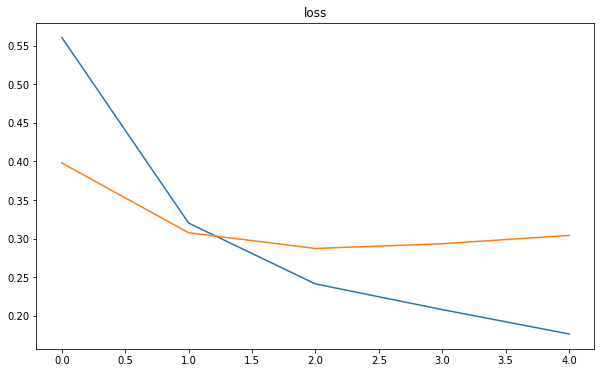

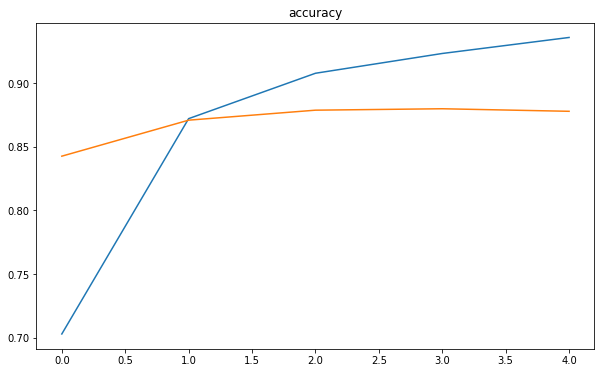

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

The Bidirectional-LSTM model overfits a lot. One possible way to reduce the overfitting is to add Dropout layer(s). This kind of layer deactivate some neurons based on an input probability: higher probability implies a high number of neurons will be deactivated.

I tried to insert the Dropout layer in different positions (between Input and Bidirectional-LSTM, and between Bidirectional-LSTM and Dense) and I even tried different rates for Dropout. In the end, the model that is able to reduce the overfitting problem better than other models is that with one Dropout layer, a rate value equal to 0.4 and between the Input layer and the Bidirectional-LSTM layer.

I noticed that the Dropout layer between Bidirectional-LSTM layer and Dense layer doesn't reduce the overfitting substantially.

*Is it possible to modify the values of some other hyper-parameters to mitigate overfitting?*

I built other models to try to mitigate the overfitting problem.

In this model, I changed the number of LSTM units from 32 to 12. We can see that this change mitigates the overfitting phenomenon. The reason is that the use of fewer units implies a less expressiveness of the network. So, in this way, I could reduce the variance of the model but I increased the bias.

In [10]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(12)))
model_bidirectional.add(keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 24)                2208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 102,233
Trainable params: 102,233
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/5
196/196 [==============================] - 75s 363ms/step - loss: 0.6514 - accuracy: 0.5957 - val_loss: 0.4320 - val_accuracy: 0.8358
Epoch 2/5
196/196 [==============================] - 70s 357ms/step - loss: 0.3628 - accuracy: 0.8630 - val_loss: 0.3637 - val_accuracy: 0.8455
Epoch 3/5
196/196 [==============================] - 69s 354ms/step - loss: 0.2566 - accuracy: 0.9060 - val_loss: 0.3293 - val_accuracy: 0.8618
Epoch 4/5
196/196 [==============================] - 73s 371ms/step - loss: 0.2043 - accuracy: 0.9307 - val_loss: 0.3437 - val_accuracy: 0.8666
Epoch 5/5
196/196 [==============================] - 70s 358ms/step - loss: 0.1718 - accuracy: 0.9452 - val_loss: 0.3445 - val_accuracy: 0.8676


391/391 - 15s - loss: 0.3100 - accuracy: 0.8786
accuracy: 87.86%


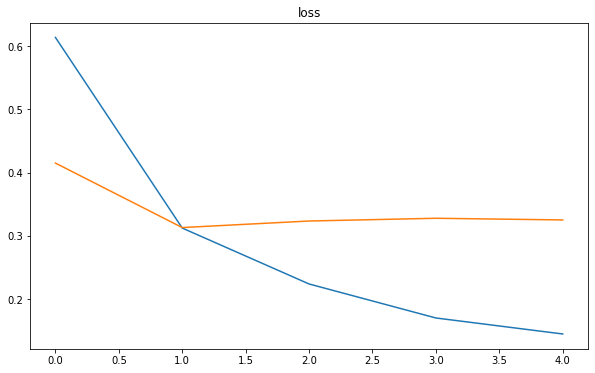

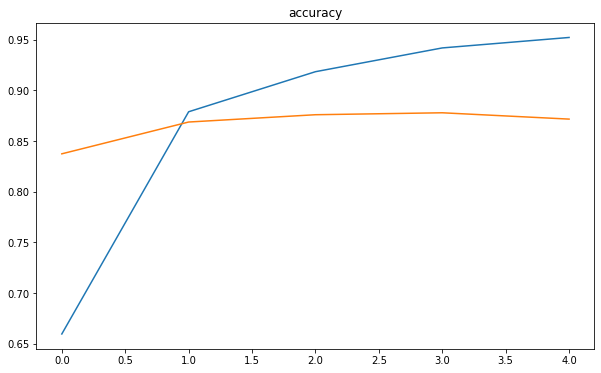

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In this model the batch size has been reduced from 128 to 64.

In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=64, validation_data=(X_valid_trim, y_valid))

Epoch 1/5
391/391 [==============================] - 163s 407ms/step - loss: 0.5801 - accuracy: 0.6598 - val_loss: 0.3071 - val_accuracy: 0.8702
Epoch 2/5
391/391 [==============================] - 158s 403ms/step - loss: 0.2722 - accuracy: 0.8955 - val_loss: 0.3022 - val_accuracy: 0.8720
Epoch 3/5
391/391 [==============================] - 160s 409ms/step - loss: 0.1777 - accuracy: 0.9365 - val_loss: 0.3265 - val_accuracy: 0.8744
Epoch 4/5
391/391 [==============================] - 161s 412ms/step - loss: 0.1412 - accuracy: 0.9524 - val_loss: 0.3247 - val_accuracy: 0.8678
Epoch 5/5
391/391 [==============================] - 162s 415ms/step - loss: 0.2553 - accuracy: 0.9075 - val_loss: 0.3570 - val_accuracy: 0.8617


391/391 - 20s - loss: 0.3480 - accuracy: 0.8726
accuracy: 87.26%


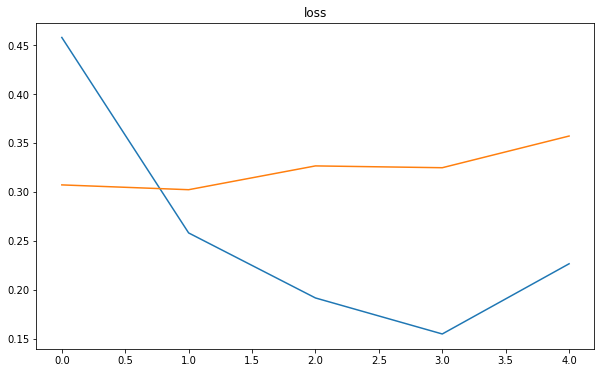

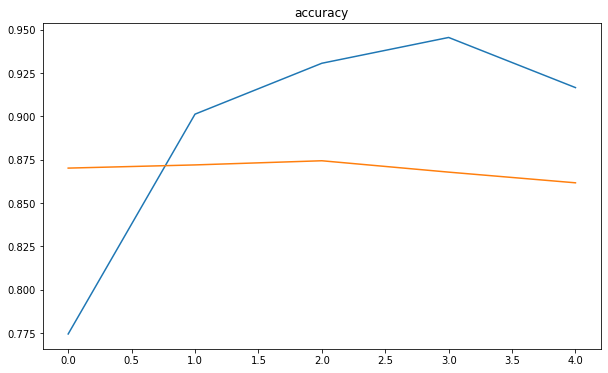

In [18]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Increasing the batch size reduced the overfitting problem: the model with the Dropout layer has a loss equal to 0.2934 and an accuracy of 88.42%, instead, this model (with a batch size equal to 256) has a loss equal to 0.2904 and an accuracy of 87.78%. We can see that this model has achieved a smaller value of the loss function. On the other side, the model with a small batch size (64) has a loss equal to 0.3480 and an accuracy of 87.26%.

Using a smaller batch size is like using some regularization effect and a lower generalization error. Generally, smaller batches lead to noisier gradient estimates (than gradients calculated with large batch size) and are better capable to escape poor local minima and prevent overfitting. On the other hand, tiny batches may be too noisy for good learning. Moreover, the smaller the batch size, the more updates. When using smaller batches, the algorithm performs more weight updates per epoch and it converge faster. So, in this case, we can see that the model with a larger batch size has achieved better perfomance than the model with a smaller batch size. The reason could be that larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model exemplified by lower variance in binary classification accuracy.

In the end, larger batch size does less work (less weight updates per epoch) and is faster to execute.

In [19]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=256, validation_data=(X_valid_trim, y_valid))

Epoch 1/5
98/98 [==============================] - 91s 891ms/step - loss: 0.6727 - accuracy: 0.5731 - val_loss: 0.5347 - val_accuracy: 0.7948
Epoch 2/5
98/98 [==============================] - 86s 880ms/step - loss: 0.4848 - accuracy: 0.8041 - val_loss: 0.4260 - val_accuracy: 0.8186
Epoch 3/5
98/98 [==============================] - 85s 870ms/step - loss: 0.3694 - accuracy: 0.8590 - val_loss: 0.3575 - val_accuracy: 0.8537
Epoch 4/5
98/98 [==============================] - 85s 872ms/step - loss: 0.2753 - accuracy: 0.9010 - val_loss: 0.3142 - val_accuracy: 0.8674
Epoch 5/5
98/98 [==============================] - 90s 924ms/step - loss: 0.2129 - accuracy: 0.9232 - val_loss: 0.3058 - val_accuracy: 0.8698


391/391 - 20s - loss: 0.2904 - accuracy: 0.8778
accuracy: 87.78%


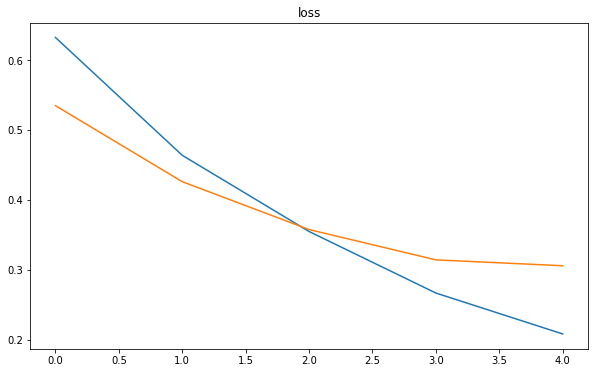

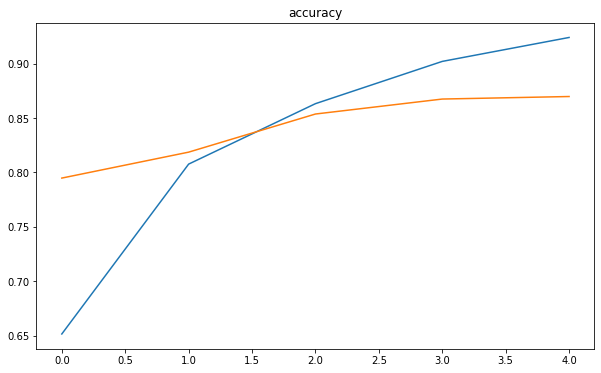

In [21]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In this model, I have increased the number of epochs, from 5 to 15. But, this change has improved the problem of overfitting. 15 is not a high number of epochs, so the reasons could be that the model should be regularized and/or need more training data to achieve good performance.

In [22]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=15, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/15
196/196 [==============================] - 125s 620ms/step - loss: 0.6330 - accuracy: 0.6158 - val_loss: 0.3821 - val_accuracy: 0.8378
Epoch 2/15
196/196 [==============================] - 122s 621ms/step - loss: 0.2954 - accuracy: 0.8855 - val_loss: 0.3355 - val_accuracy: 0.8682
Epoch 3/15
196/196 [==============================] - 124s 632ms/step - loss: 0.2068 - accuracy: 0.9244 - val_loss: 0.3009 - val_accuracy: 0.8783
Epoch 4/15
196/196 [==============================] - 131s 666ms/step - loss: 0.1680 - accuracy: 0.9434 - val_loss: 0.3203 - val_accuracy: 0.8762
Epoch 5/15
196/196 [==============================] - 136s 692ms/step - loss: 0.1376 - accuracy: 0.9553 - val_loss: 0.3249 - val_accuracy: 0.8710
Epoch 6/15
196/196 [==============================] - 130s 666ms/step - loss: 0.1204 - accuracy: 0.9627 - val_loss: 0.4110 - val_accuracy: 0.8636
Epoch 7/15
196/196 [==============================] - 129s 657ms/step - loss: 0.1040 - accuracy: 0.9668 - val_loss: 0.4414 -

391/391 - 20s - loss: 0.5737 - accuracy: 0.8558
accuracy: 85.58%


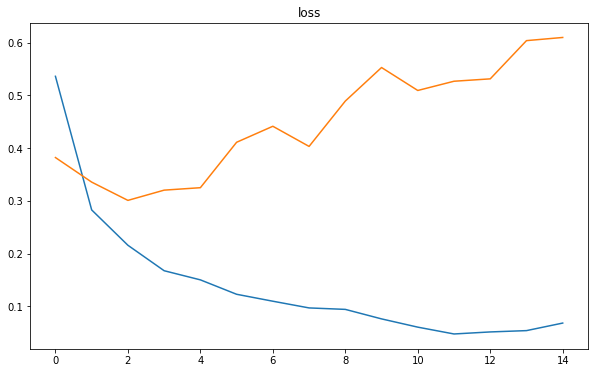

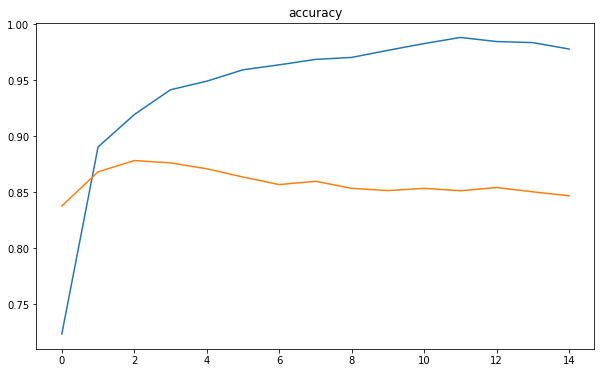

In [24]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Using a less number of epoch has helped to slightly mitigate the overfitting problem. This model has reached a comparable performances respect to the best previous models.

In [9]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=4, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/4
196/196 [==============================] - 104s 513ms/step - loss: 0.6348 - accuracy: 0.6041 - val_loss: 0.3995 - val_accuracy: 0.8374
Epoch 2/4
196/196 [==============================] - 99s 505ms/step - loss: 0.3362 - accuracy: 0.8657 - val_loss: 0.3188 - val_accuracy: 0.8673
Epoch 3/4
196/196 [==============================] - 99s 504ms/step - loss: 0.2289 - accuracy: 0.9150 - val_loss: 0.3081 - val_accuracy: 0.8734
Epoch 4/4
196/196 [==============================] - 99s 504ms/step - loss: 0.1738 - accuracy: 0.9394 - val_loss: 0.3152 - val_accuracy: 0.8712


391/391 - 16s - loss: 0.3005 - accuracy: 0.8774
accuracy: 87.74%


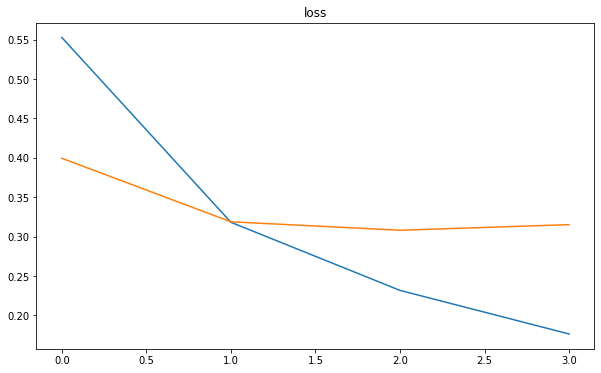

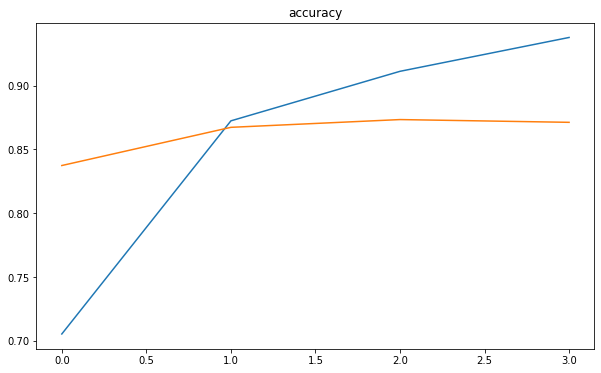

In [11]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))